<a href="https://colab.research.google.com/github/tamayodb/CCMACLRL_EXERCISES_COM222ML/blob/main/EXERCISE7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [210]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [211]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [212]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

**Validation Set**

Use this set to evaluate your model

In [213]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [214]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [215]:
df_train.head(10)

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",1
6,Leni Kiko,0
7,Nahiya si Binay sa Makati kaya dito na lang sa...,1
8,Another reminderHalalan,0
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,0


2. Check how many rows and columns are in the training dataset using `.info()`

In [216]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [217]:
df_train.isnull().sum()

,0
text,0
label,0


4. Check for duplicate rows

In [218]:
df_train.duplicated().sum()

0

5. Check how many rows belong to each class

In [219]:
df_train['label'].value_counts()

,count
label,
1,10994
0,10779


## B. Text pre-processing

6. Remove duplicate rows

In [220]:
df_train.drop_duplicates(inplace=True)

7. Remove rows with NaN values

In [221]:
df_train.dropna(inplace=True)

8. Convert all text to lowercase

In [222]:
df_train['text'] = df_train['text'].str.lower()
df_validation['text'] = df_train['text'].str.lower()
df_test['text'] = df_train['text'].str.lower()

In [223]:
df_train.head()

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang may mali na sumunod ang patalastas ng n...,1
2,bet ko. pula ang kulay ng posas,1
3,[username] kakampink,0
4,bakit parang tahimik ang mga pink about doc wi...,1


9. Remove digits, URLS and special characters

In [224]:
# Function to clean the text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove special characters (keeping only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the cleaning function to each DataFrame
df_train['text'] = df_train['text'].apply(clean_text)
df_validation['text'] = df_validation['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)

# Display cleaned DataFrames
print("Cleaned df_train:\n", df_train)
print("Cleaned df_validation:\n", df_validation)
print("Cleaned df_test:\n", df_test)


Cleaned df_train:
                                                     text  label
0      presidential candidate mar roxas implies that ...      1
1      parang may mali na sumunod ang patalastas ng n...      1
2                         bet ko pula ang kulay ng posas      1
3                                     username kakampink      0
4      bakit parang tahimik ang mga pink about doc wi...      1
...                                                  ...    ...
21768                   marcos talunan marcos magnanakaw      1
21769                               grabe kayo kay binay      0
21770  username cnu ba naman ang hindimabibighani sa ...      0
21771  rt username tabi tabi yung mga nagsasabing par...      1
21772  honestly i dont get kakampinks like pano nila ...      1

[21773 rows x 2 columns]
Cleaned df_validation:
                                                    text  label
0     presidential candidate mar roxas implies that ...      1
1     parang may mali na sumunod ang 

10. Remove stop words

In [225]:
from sklearn.feature_extraction.text import CountVectorizer

# Built-in English stop words.
english_stop_words = CountVectorizer(stop_words='english').get_stop_words()

# Generated by ChatGPT.
filipino_stop_words1 = [
    "ako", "akin", "ako'y", "amin", "aming", "ang", "ano", "anuman", "apat", "at", "atin", "ating",
    "ay", "bababa", "bago", "bakit", "bawat", "bilang", "dahil", "dalawa", "dapat", "din", "dito", "doon",
    "gagawin", "gayunman", "ginagawa", "ginawa", "ginawang", "gumawa", "gusto", "habang", "hanggang", "hindi", "huwag", "iba",
    "ibaba", "ibabaw", "ibig", "ikaw", "ilagay", "ilalim", "ilan", "inyong", "isa", "isang", "ito", "iyo",
    "iyon", "iyong", "ka", "kahit", "kailangan", "kailanman", "kami", "kanila", "kanilang", "kanino", "kanya", "kanyang",
    "kapag", "kapwa", "karamihan", "katiyakan", "katulad", "kay", "kaya", "kaysa", "ko", "kung", "laban",
    "lahat", "lamang", "likod", "lima", "maaari", "maaaring", "maging", "mahusay", "makita", "marami", "marapat", "mga",
    "minsan", "mismo", "mula", "muli", "na", "nabanggit", "naging", "nagkaroon", "nais", "nakita", "namin", "napaka",
    "narito", "nasaan", "ng", "nga", "ngayon", "ni", "nila", "nilang", "nito", "niya", "niyang", "noon",
    "o", "pag", "pala", "para", "pati", "pero", "pumunta", "pumupunta", "sa", "saan", "sabi", "sabihin",
    "sarili", "si", "sila", "sino", "siya", "tatlo", "tayo", "tulad", "tungkol", "una", "walang"
]

# From an open-source GitHub repo (ref: https://github.com/stopwords-iso/stopwords-tl).
filipino_stop_words2 = [
    'ako', 'sa', 'akin', 'ko', 'aking', 'sarili', 'kami', 'atin', 'ang', 'aming', 'amin', 'ating',
    'ka', 'iyong', 'iyo', 'inyong', 'siya', 'kanya', 'mismo', 'ito', 'nito', 'kanyang', 'sila', 'nila',
    'kanila', 'kanilang', 'kung', 'ano', 'alin', 'sino', 'kanino', 'na', 'mga', 'iyon', 'am', 'ay',
    'maging', 'naging', 'mayroon', 'may', 'nagkaroon', 'pagkakaroon', 'gumawa', 'ginagawa', 'ginawa', 'paggawa',
    'ibig', 'dapat', 'maaari', 'marapat', 'kong', 'ikaw', 'tayo', 'hindi', 'namin', 'gusto', 'nais',
    'niyang', 'nilang', 'niya', 'huwag', 'ginawang', 'gagawin', 'maaaring', 'sabihin', 'narito', 'kapag', 'ni',
    'nasaan', 'bakit', 'paano', 'kailangan', 'walang', 'katiyakan', 'isang', 'at', 'pero', 'o', 'dahil',
    'bilang', 'hanggang', 'habang', 'ng', 'pamamagitan', 'para', 'tungkol', 'laban', 'pagitan', 'panahon', 'bago',
    'pagkatapos', 'itaas', 'ibaba', 'mula', 'pataas', 'pababa', 'palabas', 'ibabaw', 'ilalim', 'muli', 'pa',
    'minsan', 'dito', 'doon', 'saan', 'lahat', 'anumang', 'kapwa', 'bawat', 'ilan', 'karamihan', 'iba', 'tulad',
    'lamang', 'pareho', 'kaya', 'kaysa', 'masyado', 'napaka', 'isa', 'bababa', 'kulang', 'marami', 'ngayon',
    'kailanman', 'sabi', 'nabanggit', 'din', 'kumuha', 'pumunta', 'pumupunta', 'ilagay', 'makita', 'nakita',
    'katulad', 'mahusay', 'likod', 'kahit', 'paraan', 'noon', 'gayunman', 'dalawa', 'tatlo', 'apat', 'lima',
    'una', 'pangalawa'
]

# Get the union of the two Filipino stop words lists.
filipino_stop_words = list(set(filipino_stop_words1).union(set(filipino_stop_words2)))

# Get the union of the English and Filipino stop words lists.
custom_stop_words = list(english_stop_words.union(filipino_stop_words))

# Define a function to remove stop words using the custom stop words list
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word.lower() not in custom_stop_words])

# Apply the function to clean the datasets
df_train['text'] = df_train['text'].apply(remove_stopwords)
df_validation['text'] = df_validation['text'].apply(remove_stopwords)
df_test['text'] = df_test['text'].apply(remove_stopwords)

# Print the cleaned datasets
print("Cleaned df_train:\n", df_train)
print("Cleaned df_validation:\n", df_validation)
print("Cleaned df_test:\n", df_test)


Cleaned df_train:
                                                     text  label
0      presidential candidate mar roxas implies govt ...      1
1      parang mali sumunod patalastas nescaf coffee b...      1
2                                   bet pula kulay posas      1
3                                     username kakampink      0
4      parang tahimik pink doc willie ong reaction paper      1
...                                                  ...    ...
21768                   marcos talunan marcos magnanakaw      1
21769                                   grabe kayo binay      0
21770  username cnu ba naman hindimabibighani maamkak...      0
21771  rt username tabi tabi yung nagsasabing parang ...      1
21772  honestly dont kakampinks like pano nasabi maga...      1

[21773 rows x 2 columns]
Cleaned df_validation:
                                                    text  label
0     presidential candidate mar roxas implies govt ...      1
1     parang mali sumunod patalastas 

11. Use Stemming or Lemmatization

In [226]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_text(text):
  return " ".join([stemmer.stem(word) for word in text.split()])

def lemmatize_text(text):
  return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df_train['text'] = df_train['text'].apply(stem_text)
df_validation['text'] = df_validation['text'].apply(stem_text)
df_test['text'] = df_test['text'].apply(stem_text)

print("Cleaned df_train:\n", df_train)
print("Cleaned df_validation:\n", df_validation)
print("Cleaned df_test:\n", df_test)

Cleaned df_train:
                                                     text  label
0      presidenti candid mar roxa impli govt liabl la...      1
1      parang mali sumunod patalasta nescaf coffe bla...      1
2                                    bet pula kulay posa      1
3                                      usernam kakampink      0
4       parang tahimik pink doc willi ong reaction paper      1
...                                                  ...    ...
21768                     marco talunan marco magnanakaw      1
21769                                   grabe kayo binay      0
21770  usernam cnu ba naman hindimabibighani maamkaka...      0
21771  rt usernam tabi tabi yung nagsasab parang tang...      1
21772  honestli dont kakampink like pano nasabi magan...      1

[21773 rows x 2 columns]
Cleaned df_validation:
                                                    text  label
0     presidenti candid mar roxa impli govt liabl la...      1
1     parang mali sumunod patalasta n

## C. Training your model

12. Put all text training data in variable **X_train**

In [227]:
X_train = df_train['text']

13. Put all training data labels in variable **y_train**

In [228]:
y_train = df_train['label']

In [229]:
# # Hyperparameter tuning using GridSearchCV.

# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline

# # Create a pipeline with CountVectorizer and MultinomialNB.
# pipe = Pipeline([
#     ('cvec', CountVectorizer()),
#     ('mnb', MultinomialNB())
# ])

# # Create a dictionary of parameters to search.
# params = {
#     'cvec__stop_words': [custom_stop_words],
#     'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
#     'cvec__min_df': [1, 2, 3, 4],
#     'cvec__max_df': [0.01, 0.1, 0.2, 0.3],
#     'mnb__alpha': [0.01, 0.1, 1.0, 10.0],
# }

# # Instantiate GridSearchCV.
# gs = GridSearchCV(pipe, param_grid=params, cv=5, verbose=2, n_jobs=-1, scoring='accuracy', refit=True)

# # Fit GridSearch to training data.
# gs.fit(X_train, y_train)
# gs.best_params_

14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [230]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_train_transformed = vectorizer.fit_transform(X_train)


15. Create an instance of `MultinomalNB()`

In [231]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()


16. Train the model using `.fit()`

In [232]:

model.fit(X_train_transformed, y_train)


MultinomialNB()

## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [233]:
X_validation = df_validation['text']

X_validation_transformed = vectorizer.transform(X_validation)

y_validation_pred = model.predict(X_validation_transformed)


18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [234]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_validation = df_validation['label']

accuracy = accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred)
recall = recall_score(y_validation, y_validation_pred)
f1 = f1_score(y_validation, y_validation_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Accuracy: 0.5128571428571429
Precision: 0.5166994106090373
Recall: 0.5575971731448763
F1-Score: 0.5363698164513936


19. Create a confusion matrix using the **validation dataset**

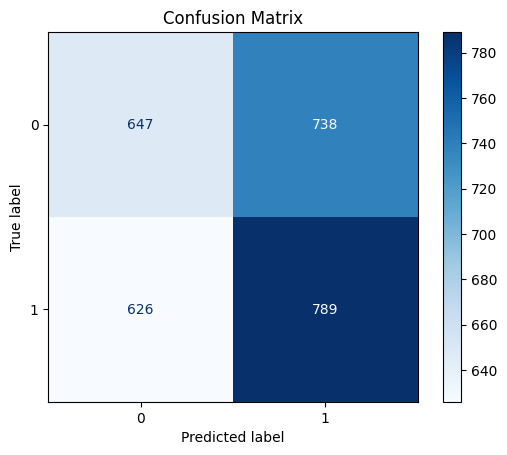

In [235]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_validation, y_validation_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])


disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [236]:
X_test = df_test['text']
X_test_transformed = vectorizer.transform(X_test)
y_test_pred = model.predict(X_test_transformed)

21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [237]:
y_test = df_test['label']

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.500355871886121
Precision: 0.4980443285528031
Recall: 0.5464949928469242
F1-Score: 0.5211459754433834


22. Create a confusion matrix using the **test dataset**

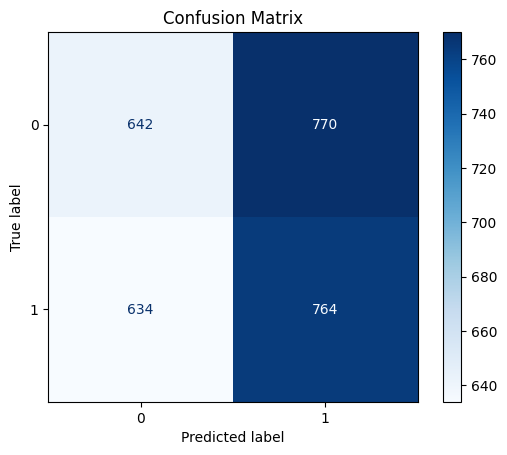

In [238]:
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])


disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [239]:
def try_model():
    new_input = input("Input: ")
    new_input_transformed = vectorizer.transform([new_input])
    prediction = model.predict(new_input_transformed)
    print(f"Prediction for '{new_input}': {prediction[0]}")

try_model()

Input: Ang init ng ulo ko ang gulo gulo ng paligid ang sarap talaga sumigaw ng putang ina
Prediction for 'Ang init ng ulo ko ang gulo gulo ng paligid ang sarap talaga sumigaw ng putang ina': 1


24. Test the model by providing a hate speech input. The model should predict it as 1

In [240]:
try_model()

Input: ang sarap ng pagkain ko lalo na kapag kasama si phia
Prediction for 'ang sarap ng pagkain ko lalo na kapag kasama si phia': 0
